# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [15]:
# TODO: Make all necessary imports.
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import json
from datetime import datetime
from PIL import Image
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print('tensorflow datasets version:', tfds.__version__)
print('numpy version:', np.__version__)
print('seaborn version:', sns.__version__)

TensorFlow version: 2.2.0-dev20200506
tf.keras version: 2.2.4-tf
tensorflow datasets version: 3.1.0
numpy version: 1.18.1
seaborn version: 0.10.1


In [16]:
#some setup commands
%matplotlib inline

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [17]:
# TODO: Load the dataset with TensorFlow Datasets.
#fix checksum problems, see Peer Chat and github
#%pip --no-cache-dir install tfds-nightly

In [18]:
#download manually
# download data to default directory "~/tensorflow_datasets"
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102
#restart kernel

In [26]:
#load as dataset object
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

In [27]:
#check dataset
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [21]:
# TODO: Create a training set, a validation set and a test set.
train_set = dataset['train']
val_set = dataset['validation']
test_set = dataset['test']
train_set

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## Explore the Dataset

In [22]:
# TODO: Get the number of examples in each set from the dataset info.
n_train = dataset_info.splits['train'].num_examples
n_val = dataset_info.splits['validation'].num_examples
n_test = dataset_info.splits['test'].num_examples

print(f"Number of examples in train set: {n_train}")
print(f"Number of examples in val set: {n_val}")
print(f"Number of examples in test set: {n_test}")

# TODO: Get the number of classes in the dataset from the dataset info.
n_features = dataset_info.features['label'].num_classes
print(f"Number of features: {n_features}")

Number of examples in train set: 1020
Number of examples in val set: 1020
Number of examples in test set: 6149
Number of features: 102


In [23]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in train_set.take(3):
    image = image.numpy()
    label = label.numpy()
    print(f"shape : {image.shape}")
    print(f"label : {label}")
    
print("shapes vary significantly, reshape later, 3 color channels")

shape : (500, 667, 3)
label : 72
shape : (500, 666, 3)
label : 84
shape : (670, 500, 3)
label : 70
shapes vary significantly, reshape later, 3 color channels


tf.Tensor(72, shape=(), dtype=int64)


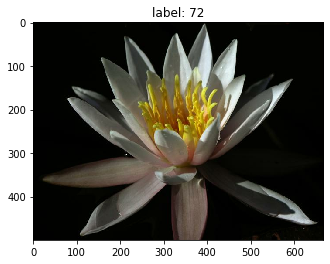

In [29]:
# TODO: Plot 1 image from the training set. Set the title of the plot to the corresponding image label. 
for image, label in train_set.take(1):
    image = image.numpy()
    print(label)
    label = label.numpy()
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
#load JSON file for mapping
with open('label_map.json', 'r') as f:
    class_names = json.load(f)  #dict

In [111]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

**Caution**: Labels in dataset seamm to be zero-indexed but the class<->label dict is not!

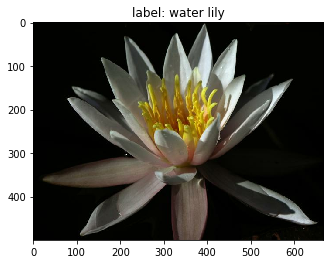

In [35]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in train_set.take(1):
    image = image.numpy()
    label = class_names[str(label.numpy()+1)]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show

## Create Pipeline

In [36]:
for image, label in train_set.take(1):
    n_pixels = image.numpy().max()
print(n_pixels)

255


In [84]:
# TODO: Create a pipeline for each set.
BATCH_SIZE = 32
SIZE = 224

#resize, cast and normalize
def format_image(image, label):
    """cast, resize and normalize image"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (SIZE, SIZE))
    image = image /n_pixels
    #image = image.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
    
    return image, label

def augment_image(image, label):
    """augment by fliiping etc."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, 0.7, 1.0)
    image = tf.image.random_saturation(image, 0.7, 1.0)
    #image = tf.keras.preprocessing.image.random_zoom(image, (0.8,0.8))
    
    return image, label
    
train_batches = train_set.shuffle(n_train//5).map(format_image).map(augment_image).batch(BATCH_SIZE).prefetch(1)
val_batches = val_set.shuffle(n_val//5).map(format_image).map(augment_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.shuffle(n_test//5).map(format_image).batch(BATCH_SIZE).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the **MobileNet** pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [65]:
# TODO: Build and train your network.
#load MobileNet
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(SIZE, SIZE,3))
feature_extractor.trainable = False

In [66]:
#include into model
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(n_features, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [97]:
#compile and fit model
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics =  ['accuracy'])

EPOCHS = 25
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10,
                                              min_delta = 0.05, restore_best_weights = True, verbose = 1)

history = model.fit(train_batches, 
                    epochs = EPOCHS, 
                    validation_data = val_batches, 
                    callbacks = [early_stop])

Epoch 1/25
32/32 [==============================] - 40s 1s/step - loss: 0.0485 - accuracy: 0.9882 - val_loss: 0.7634 - val_accuracy: 0.7990
Epoch 2/25
32/32 [==============================] - 39s 1s/step - loss: 0.0402 - accuracy: 0.9912 - val_loss: 0.7320 - val_accuracy: 0.8020
Epoch 3/25
32/32 [==============================] - 39s 1s/step - loss: 0.0338 - accuracy: 0.9980 - val_loss: 0.7211 - val_accuracy: 0.8157
Epoch 4/25
32/32 [==============================] - 40s 1s/step - loss: 0.0175 - accuracy: 0.9990 - val_loss: 0.7308 - val_accuracy: 0.7971
Epoch 5/25
32/32 [==============================] - 38s 1s/step - loss: 0.0157 - accuracy: 0.9990 - val_loss: 0.7022 - val_accuracy: 0.8186
Epoch 6/25
32/32 [==============================] - 40s 1s/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.6943 - val_accuracy: 0.8029
Epoch 7/25
32/32 [==============================] - 40s 1s/step - loss: 0.0193 - accuracy: 0.9980 - val_loss: 0.7363 - val_accuracy: 0.8020
Epoch 8/25
32/32 [==

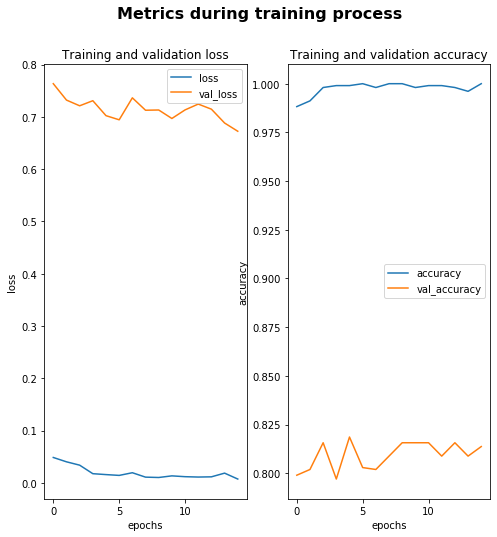

In [98]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
def plot_train_metrics(history):
    """
    Visualizes training and validation metrics during training as function of epochs
    
    Parameters:
    history [] - history object returned from Model.fit() method
    
    Returns:
    None
    """
    
    #grab data from history object
    epochs = len(history.history[list(history.history.keys())[0]])
    metrics = list(history.history.keys())
    metrics_values = list(history.history.values())
    n_metrics = len(metrics)//2
    
    #plot it
    fig = plt.figure(figsize=(8, 8)) 
    for i in range(n_metrics):
        
        plt.subplot(1, n_metrics, i+1)
        metrics_i = metrics[i::n_metrics] #every n_metrics value
        metrics_values_i = metrics_values[i::n_metrics]
        
        plt.plot(range(epochs), metrics_values_i[0], label=metrics_i[0])
        plt.plot(range(epochs), metrics_values_i[1], label=metrics_i[1])
        plt.ylabel(metrics_i[0])
        plt.xlabel("epochs")
        plt.legend(loc='best' )
        plt.title(f'Training and validation {metrics_i[0]}')
    
    fig.suptitle("Metrics during training process", fontsize = 16,  fontweight = 'bold')
    plt.show()
    
    return None
                
plot_train_metrics(history)

Model needed only 10 epochs till callback early_stopping.

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [99]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
prediction = model.evaluate(test_batches)
print(f"On test set: loss {prediction[0]:.2f} and accuracy {prediction[1]*100:.2f}%")

#non-augmented: On test set: loss 0.80 and accuracy 79.41%
#augmented with flip and brightness: loss 1.03 and accuracy 77.02%
#patience 5, min_d = 0.03 flip. birghtness, saturation, contrast: 6 epochs, 77,64%
#patience 10, min_d = 0.05 flip. birghtness, saturation, contrast: 15 epochs, 77,64%

193/193 [==============================] - 120s 624ms/step - loss: 0.7984 - accuracy: 0.7905
On test set: loss 0.80 and accuracy 79.05%


In [91]:
def check_predictions_vis(model, test_batches):
    """
    check predictions vs. test data visually for first batch
    title shows predicted class and color-coded matches
    calculates accuracy on complete test batch
    
    Parameters:
    model [Keras model object] - trained Keras Model Object
    test_batches [tf Datasets] - batches of test data to run predicitons on
    
    Returns:
    None
    """
        
    #batch size
    n_batch = 0
    for i, element in test_batches.take(1).unbatch().enumerate():
        n_batch+=1
    
    #take the first batch and fetch data
    for image_batch, label_batch in test_batches.take(1):
        predictions = model.predict(image_batch)
        images = image_batch.numpy().squeeze()
        labels = label_batch.numpy()

        fig = plt.figure(figsize=(10,15))
        fig.suptitle('Images of one batch with color-coded predictions', fontsize=16)

        #compute subplot dimensions
        n_columns = 5
        
        if n_batch % n_columns:
            n_rows = n_batch // n_columns + 1 
        else:
            n_rows = n_batch // n_columns
    
        for n in range(n_batch):
            plt.subplot(n_rows, n_columns, n+1)
            plt.imshow(images[n], cmap = plt.cm.binary)
            color = 'g' if np.argmax(predictions[n]) == labels[n] else 'r'
            plt.title(np.argmax(predictions[n]), color=color)
            plt.axis('off')
        
        accuracy = (np.sum(np.argmax(predictions, axis = 1) == labels)) / n_batch
        
    
    plt.show()
    print(f"Accuracy on test batch: {accuracy * 100:.2f}% ")
    print(f"Batch size: {n_batch}")
    
    return None

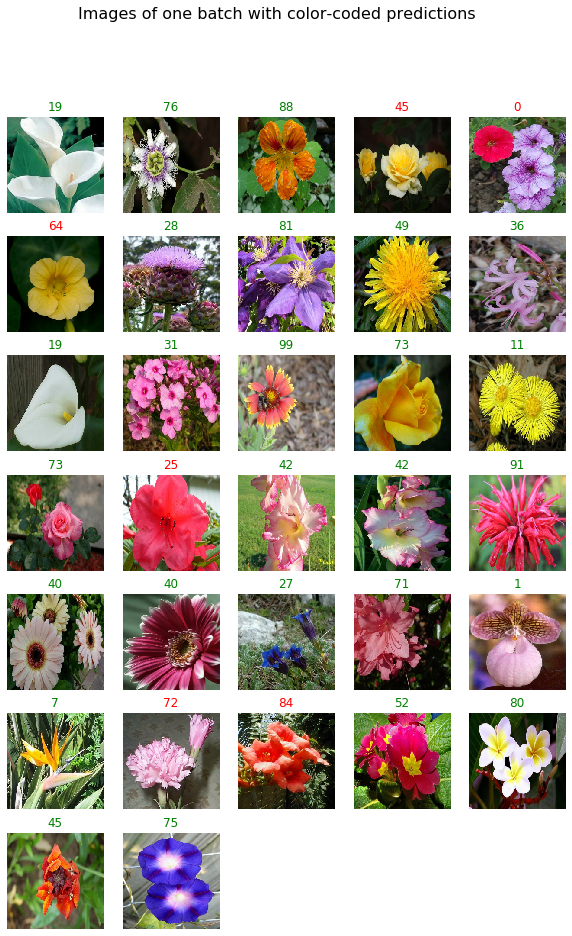

Accuracy on test batch: 81.25% 
Batch size: 32


In [92]:
check_predictions_vis(model, test_batches)

With early stopping and data augmentation model achives ~79% accuracy on test data. Pretty nice. So accuracy seems good. But let's have a look at the flowers/pictures our model does not perform well on.

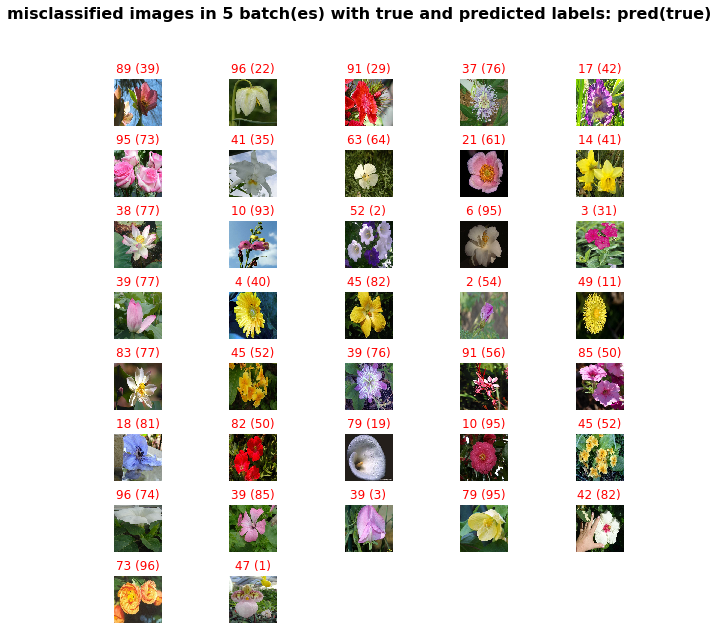

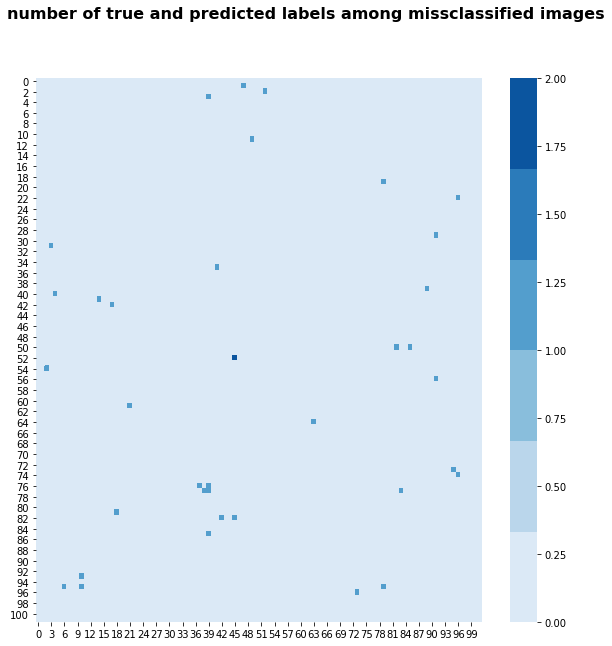

In [100]:
def show_missclassified(model, test_batches, n_batches = 1):
    """
    Shows only misclassified images and analyzes those missclassifications
    
    Parameters:
    model[Keras model object]  - trained Keras object model
    test_batches [tf Datasets] - batches of test data to use for prediction
    n_batches [int]            - number of batches that should be analyzed, default = 1
    
    Returns:
    None
    
    TO DO: try to get n_labels without using prediction (computation time)
    """
    
    missclassified = []
    right_classes = []
    pred_classes = []
    
    #get n_labels, initialize matrix
    for image_batch, label_batch in test_batches.take(1):
        #labels on rows, preds on columns
        predictions = model.predict(image_batch)
        n_labels = predictions[0].size
        labels_pred_mat = np.zeros([n_labels, n_labels], dtype = int)
    
    
    #take the batches and fetch data, gather data from missclassified images
    for image_batch, label_batch in test_batches.take(n_batches):
        
        predictions = model.predict(image_batch)
        images = image_batch.numpy().squeeze()
        labels = label_batch.numpy()
        
        for n in range(len(predictions)):
        
            pred_class = np.argmax(predictions[n])
            if  pred_class != labels[n]:
                #missclassified
                missclassified.append({'image' : images[n], 'right_class' : labels[n], 'pred_class' : pred_class  })
                right_classes.append(labels[n])
                pred_classes.append(pred_class)
                labels_pred_mat[labels[n],pred_class] += 1   
  

    #size of plot matrix
    n_missclassified = len(missclassified)
    n_elements = n_missclassified//5 * 5
    n_columns = 5
        
    if n_missclassified % n_columns:
        n_rows = n_missclassified // n_columns + 1
            
    else:
        n_rows = n_missclassified // n_columns
    
    #now plot the missclassified images
    fig_1 = plt.figure(figsize=(10,10))
    
    for i, image in enumerate(missclassified):
        plot = plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(image['image'], cmap = plt.cm.binary)
        plt.title(f"{image['pred_class']} ({image['right_class']})", color='r')
        plt.axis('off')
        
    #styling    
    fig_1.suptitle(f"misclassified images in {n_batches} batch(es) with true and predicted labels: pred(true)", fontsize = 16, fontweight = 'bold')   
    fig_1.subplots_adjust(hspace = 0.5)
    plt.show()
    
    #plot true vs. pred matrix as heatmap
    fig_2 = plt.figure(figsize=(10, 10))
    sns.heatmap(labels_pred_mat, cmap = sns.color_palette("Blues"))
    fig_2.suptitle("number of true and predicted labels among missclassified images", fontsize = 16, fontweight = 'bold')  
    plt.show()
        
    
show_missclassified(model, test_batches, n_batches = 5)    

There seems to be some flowers the model has problems (e.g. label 50: common dandelion) with but no major patterns.

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [101]:
# TODO: Save your trained model as a Keras model.
dt = datetime.now()
dt = datetime.strftime(dt, "%Y%m%d_%H%M%S")
val_acc = np.mean(history.history['val_accuracy'])
model.save(f'image_net_oxford_flowers_{dt}_{val_acc:.2f}.h5')
#example file name image_net_oxford_flowers_20200509_133807_0.83.h5

## Load the Keras Model

Load the Keras model you saved above.

In [102]:
# TODO: Load the Keras model
saved_models = glob.glob('*.h5')
saved_models

['image_net_oxford_flowers_20200509_075248.h5',
 'image_net_oxford_flowers_20200509_105854_0.82.h5',
 'image_net_oxford_flowers_20200509_133807_0.83.h5',
 'image_net_oxford_flowers_20200511_172318_0.80.h5',
 'image_net_oxford_flowers_20200511_174947_0.81.h5',
 'test_model.h5']

In [103]:
#workaround according https://github.com/tensorflow/tensorflow/issues/26835
reloaded_model = tf.keras.models.load_model("./image_net_oxford_flowers_20200511_174947_0.81.h5",custom_objects={'KerasLayer':hub.KerasLayer})
#reloaded_model = tf.keras.models.load_model(saved_models[0])

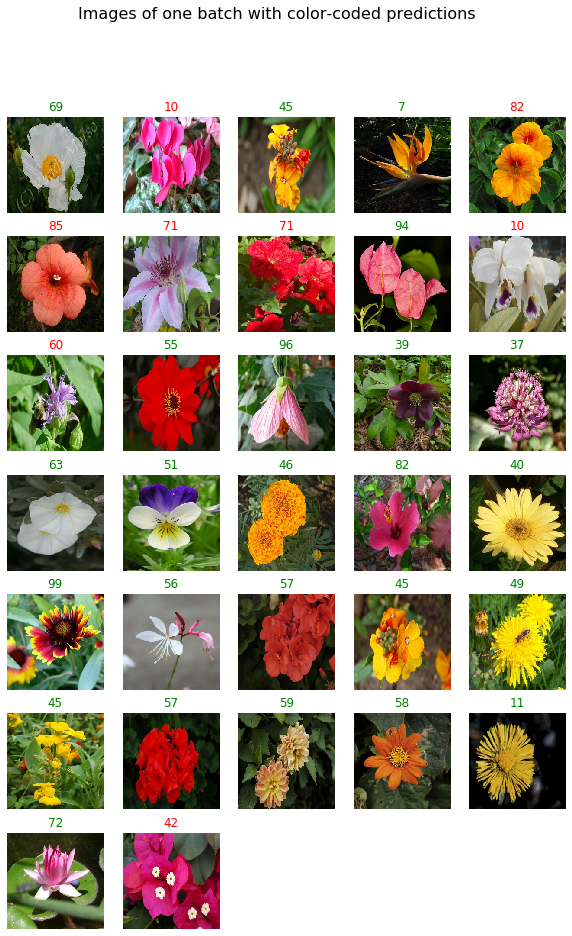

Accuracy on test batch: 75.00% 
Batch size: 32


In [104]:
#check reloaded model, sanity check
check_predictions_vis(reloaded_model, test_batches)

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [105]:
# TODO: Create the process_image function
def process_image(image):
    """
    converts image (numpy array) to numpy array with shape (224,224,3)
    
    Parameters:
    image [np.array] - image
    
    Returns:
    image_processed [np.array] - reshaped image (224,224,3)
    """
    
    image_tensor = tf.convert_to_tensor(image)
    image_processed = tf.image.resize(image_tensor, size = (224,224))
    image_processed = image_processed / 255.
    image_processed = image_processed.numpy()
    
    return image_processed

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

Shape of processed image: (224, 224, 3)


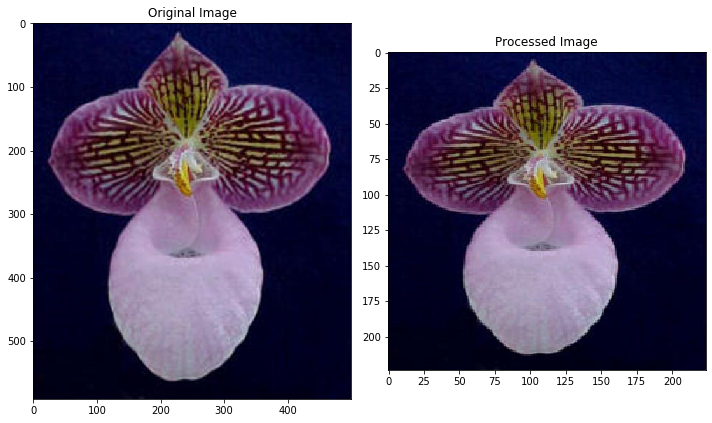

In [106]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)
print(f"Shape of processed image: {processed_test_image.shape}")

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [107]:
# TODO: Create the predict function
def predict(image_path, model, top_k = 5):
    """ 
    Uses trained network for inference. 
    
    Parameters:
    image_path [str]     - String
    model [Keras.model]  - Keras model
    top_k [int]          - number of n-highest values to return, default = 5
    
    Returns: 
    classes [np.array]   - top_k classes predicted, not zero-indexed!
    probs   [np.array]   - top_k probabilities
    
    Requires:
    from PIL import Image
    """
    
    im = Image.open(image_path)
    image = np.asarray(im)
    image_processed = process_image(image)
    image_processed = np.expand_dims(image_processed, axis = 0)
    
    predictions = model.predict(image_processed)
    
    #get n-highest, negating values results in descending argsort  
    #zero indexed classes!
    classes = np.argsort(-predictions[0])[:top_k]
    probs = np.asarray([predictions[0][classes]]).reshape(-1)
    #return non-zero indexed classes!
    classes = classes + 1
          
    return probs, classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [108]:
# TODO: Plot the input image along with the top 5 classes
def show_test_prediction(image_path, model, class_names):
    """
    Plots a test picture and the highest-ranked predictions of a model.
    
    Parameter:
    image_path [str]    - path to image file
    model [Keras.model] - trained Keras model object
    class_names [dict]  - dict of format '3' : orchid
    
    Returns:
    None
    """
    
    probs, classes = predict(image_path, model)

    fig = plt.figure(figsize=(15,6))
    fig.suptitle(f"Input image and probabilities of predicted classes {image_path}")

    #plot image
    plt.subplot(1,2,1)
    im = Image.open(image_path)
    image_processed = process_image(np.asarray(im))
    plt.imshow(image_processed)

    #plot bar plot with probs and labels
    plt.subplot(1,2,2)
    labels = [class_names[str(label)] for label in classes]
    plt.barh(labels, probs)
    fig.subplots_adjust(hspace=0.8, wspace=0.8)

    plt.show()

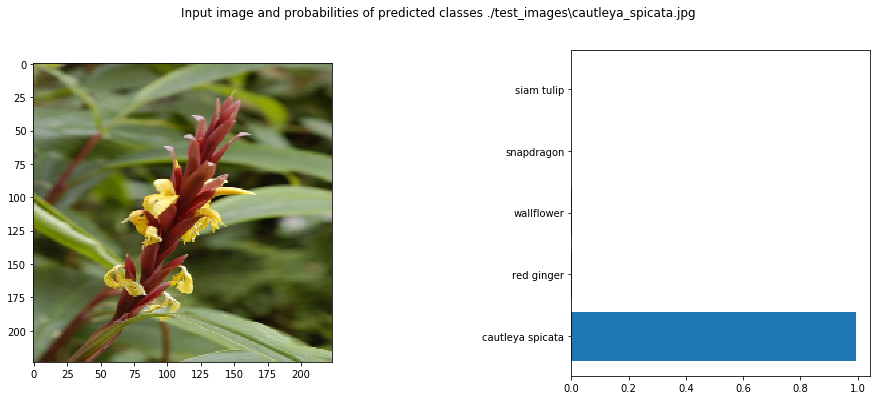

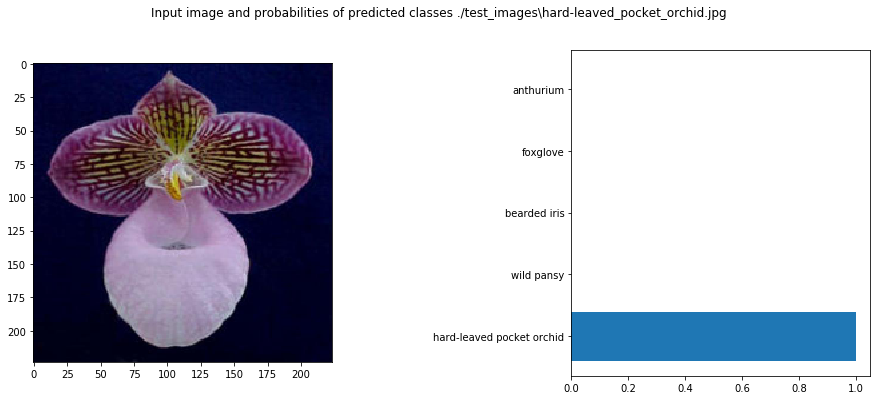

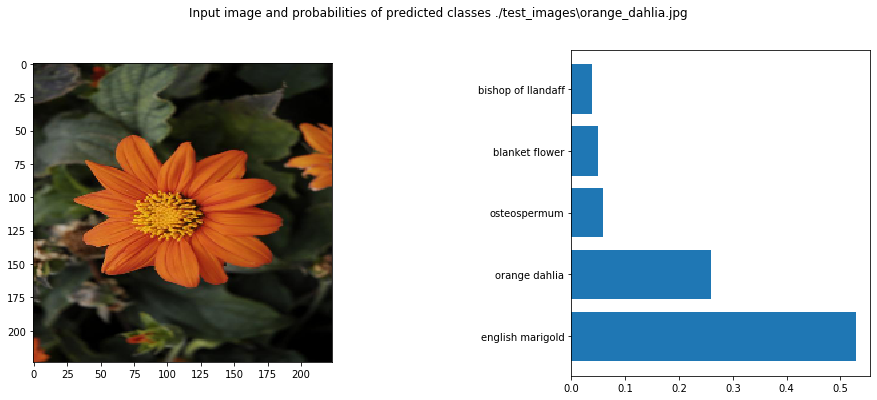

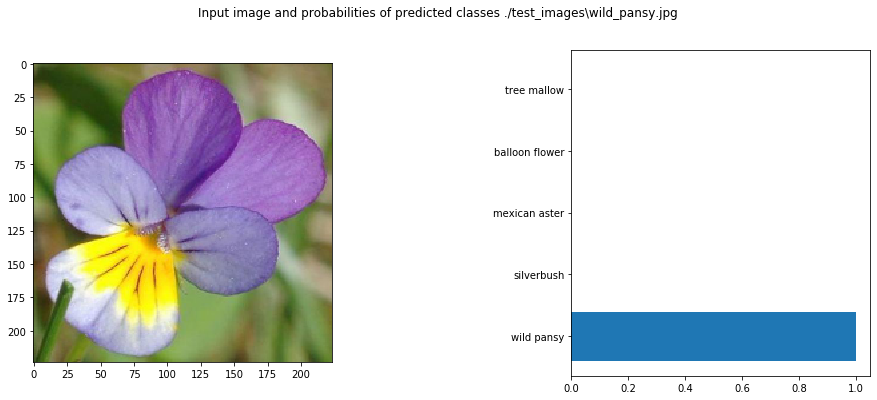

In [109]:
#test it  
image_pathes = os.listdir("./test_images")
for path in image_pathes:
    image_path = os.path.join("./test_images",path)  
    show_test_prediction(image_path, reloaded_model, class_names)

Sanity check was sucessful. 3 flowers in the test image batch were labeled correct with nearly 100% confidence.